Para maiores explicações sobre ConvNets, acesse https://docs.google.com/presentation/d/11nhIBIeVybkgzCRnTCLgEwPym35K51R_HKsgH5c3VTg/edit?usp=sharing

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from google.colab import files
from math import *
import time
from sklearn import metrics
import sklearn
import tensorflow as tf

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

## Parte 1: Exploração e pré-processamento

Nessa parte estudo um pouco de como o dataset utilizado é e como adequá-lo para as características específicas das funções propostas para a CNN.

### 1.1 Google drive

Junto com este notebook normalmente você receberá uma pasta zipada chamada Animal.zip (que você pode baixar pelo link https://www.dropbox.com/s/3d0l7nd74yv757p/Animal.zip?dl=0) que você deve deixar dentro do seu Drive. As células abaixo pedem a autorização para poderem acessar seu drive, basta permitir

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp '/content/gdrive/My Drive/Animal.zip' new
#animals = pd.read_csv('/content/new')
#animals.head()

Archive:  new
   creating: Animal/
   creating: Animal/test/
   creating: Animal/test/cats/
  inflating: Animal/test/cats/cats_00801.jpg  
  inflating: Animal/test/cats/cats_00802.jpg  
  inflating: Animal/test/cats/cats_00803.jpg  
  inflating: Animal/test/cats/cats_00804.jpg  
  inflating: Animal/test/cats/cats_00805.jpg  
  inflating: Animal/test/cats/cats_00806.jpg  
  inflating: Animal/test/cats/cats_00807.jpg  
  inflating: Animal/test/cats/cats_00808.jpg  
  inflating: Animal/test/cats/cats_00809.jpg  
  inflating: Animal/test/cats/cats_00810.jpg  
  inflating: Animal/test/cats/cats_00811.jpg  
  inflating: Animal/test/cats/cats_00812.jpg  
  inflating: Animal/test/cats/cats_00813.jpg  
  inflating: Animal/test/cats/cats_00814.jpg  
  inflating: Animal/test/cats/cats_00815.jpg  
  inflating: Animal/test/cats/cats_00816.jpg  
  inflating: Animal/test/cats/cats_00817.jpg  
  inflating: Animal/test/cats/cats_00818.jpg  
  inflating: Animal/test/cats/cats_00819.jpg  
  inflating: An

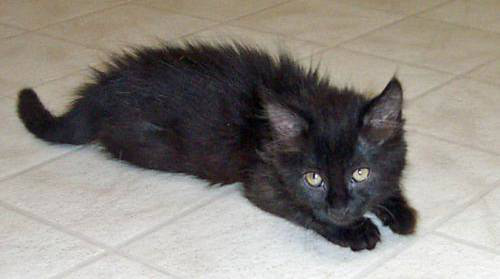

In [ ]:
!unzip new
img = tf.keras.preprocessing.image.load_img('Animal/train/cats/cats_00130.jpg')
img

Normalmente se deu tudo certo você verá a imagem de um gatinho!

A classe ImageDataGenerator é uma classe bem interessante que permite que criemos conjuntos de treino, validação e teste sem que ele esteja no formato de dataframe, o que não é tão evidente para imagens. O código abaixo foi baseado em https://studymachinelearning.com/keras-imagedatagenerator-with-flow_from_directory/. Observe que o objeto train_datagen recebe vários parâmetros. Esses parâmetros normalmente são utilizados para técnicas de data augmentation (https://towardsdatascience.com/image-data-generators-in-keras-7c5fc6928400). Observe que o set de teste não pode ser aumentado

In [34]:


src_path_train = "/content/Animal/train/"
src_path_test = "/content/Animal/test/"

train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=10,
        horizontal_flip=True,
        fill_mode="nearest",
        zoom_range=[0.8, 1.2],
        brightness_range = [0.75, 1.5],
        validation_split=0.10)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [35]:
#batch_size = 1
batch_size = 20
#batch_size = 100

#im_size = 32
im_size = 128
#im_size = 512

In [36]:
aug_img_path = '/content/Animal/Animal_aug'
train = train_datagen.flow_from_directory( 
    directory = src_path_train,
    save_format='jpeg',
    target_size = (im_size,im_size),
    color_mode = "rgb",
    batch_size = batch_size,
    class_mode = "categorical",
    subset = 'training',
    shuffle = True,
    seed = 42,
#    save_to_dir=aug_img_path, 
 #   save_prefix='aug', 
  #  save_format='jpeg'
)

valid = train_datagen.flow_from_directory(
    directory = src_path_train,
    target_size = (im_size,im_size),
    color_mode = "rgb",
    batch_size = batch_size,
    class_mode = "categorical",
    subset = 'validation',
    shuffle = True,
    seed = 42
)

test = test_datagen.flow_from_directory(
    directory = src_path_test,
    target_size = (im_size,im_size),
    color_mode = "rgb",
    batch_size = 1,
    class_mode = None,
    shuffle = False,
    seed = 42
)

Found 2160 images belonging to 3 classes.
Found 240 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


## 2 CNNs
### 2.1 CNN padrão

A CNN abaixo usa a arquitetura mais básica, uma arquitetura sequencial, com uma convolução seguida de pooling, e duas camadas completamente conectadas. Como trata-se de classificação, a última função de ativação é softmax. A loss function é a cross entropy categórica, que é a mais comum nesses casos. Essa escolha de parâmetros foi baseada no artigo https://www.geeksforgeeks.org/convolutional-neural-network-cnn-in-tensorflow/

In [37]:

def model_pipeline():
    model = Sequential()
    model.add(Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=(im_size, im_size, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Conv2D(64,kernel_size=(5,5),activation='relu'))
    #model.add(MaxPooling2D(pool_size=2, strides = 2))
    #model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(20, activation='relu'))
    #model.add(Dense(60, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
    return model

In [38]:
model = model_pipeline()
model.summary()
# É preciso usar fit_generator pois o formato que flow_from_directory entrega é diferente do habitual

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 63504)             0         
                                                                 
 dense_18 (Dense)            (None, 20)                1270100   
                                                                 
 dense_19 (Dense)            (None, 3)                 63        
                                                                 
Total params: 1,270,611
Trainable params: 1,270,611
Non-trainable params: 0
____________________________________________

Observe acima no summary como de fato a camada de convolução tem uma quantidade quase trivial dos mais de 1 milhão de parâmetros da rede. Abaixo fitamos os dados em model.fit. A acurácia final normalmente gira entre 55 e 75%

In [39]:
model.fit(train, 
          epochs = 10, 
          validation_data = valid, 
          batch_size = batch_size, 
          steps_per_epoch =  train.n//train.batch_size,
          validation_steps = valid.n//valid.batch_size
          )
#batch_size 32 pior que batch_size 10

Epoch 1/10
108/108 [==============================] - 18s 164ms/step - loss: 1.0070 - accuracy: 0.4977 - val_loss: 0.8005 - val_accuracy: 0.5917
Epoch 2/10
108/108 [==============================] - 17s 159ms/step - loss: 0.8114 - accuracy: 0.5898 - val_loss: 0.7965 - val_accuracy: 0.5750
Epoch 3/10
108/108 [==============================] - 17s 159ms/step - loss: 0.7892 - accuracy: 0.6014 - val_loss: 0.7720 - val_accuracy: 0.6083
Epoch 4/10
108/108 [==============================] - 17s 160ms/step - loss: 0.7554 - accuracy: 0.6194 - val_loss: 0.8563 - val_accuracy: 0.6000
Epoch 5/10
108/108 [==============================] - 17s 160ms/step - loss: 0.7446 - accuracy: 0.6287 - val_loss: 0.7536 - val_accuracy: 0.6208
Epoch 6/10
108/108 [==============================] - 17s 160ms/step - loss: 0.7338 - accuracy: 0.6412 - val_loss: 0.7386 - val_accuracy: 0.6667
Epoch 7/10
108/108 [==============================] - 17s 161ms/step - loss: 0.7168 - accuracy: 0.6495 - val_loss: 0.7072 - val_ac

Avaliação do modelo com o set de validação

In [40]:
score = model.evaluate(valid)
print("Loss ", score[0])
print("Accuracy ", score[1])

12/12 [==============================] - 2s 148ms/step - loss: 0.7894 - accuracy: 0.6292
Loss  0.7893760800361633
Accuracy  0.6291666626930237


A predição do testset

In [41]:
predict = model.predict(test)
y_predict = predict.argmax(axis = -1)

Abaixo tem a comparação entre a y_predict e a test.labels, ou seja, os valores preditos e o groundtruth. Vendo o test.labels, percebemos que 0 está para gatos, 1 para cachorros e 2 para pandas. Dessa forma, podemos ver onde estão as predições problemáticas e qual seria o certo



In [42]:
y_predict

array([2, 2, 1, 0, 0, 0, 0, 1, 2, 1, 2, 0, 0, 0, 2, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 1, 0, 1, 0, 0, 2, 2, 2, 0,
       2, 1, 2, 2, 2, 2, 0, 2, 1, 2, 2, 0, 2, 1, 0, 0, 2, 2, 0, 1, 2, 0,
       0, 2, 0, 2, 1, 0, 0, 0, 0, 1, 1, 0, 1, 2, 1, 0, 2, 1, 0, 0, 2, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 2,
       2, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 2, 1, 0, 0, 2, 0, 2, 2, 2,
       1, 0, 0, 0, 1, 0, 1, 2, 0, 1, 2, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2, 2,
       0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 2, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 2, 1, 0, 2, 2, 1, 2, 0, 1, 0, 1, 2, 2, 0, 2, 2, 2, 0, 1, 1,
       2, 0, 1, 1, 2, 2, 2, 1, 1, 0, 1, 2, 1, 0, 1, 2, 0, 1, 0, 1, 0, 1,
       0, 0, 2, 0, 2, 2, 1, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0,
       2, 1, 0, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 0, 1, 1, 2, 0, 2, 1,
       0, 2, 1, 2, 2, 1, 0, 1, 1, 1, 2, 2, 2, 0, 1, 1, 0, 2, 2, 1, 2, 1,
       2, 0, 1, 2, 1, 2, 1, 2, 2, 1, 0, 2, 1, 2, 0,

In [43]:
test.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [44]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(test.labels, y_predict)

print(cf_matrix)

[[100  43  57]
 [ 47  84  69]
 [  2   4 194]]


A matriz de confusão que eu obtive foi 

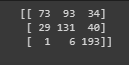

dependendo de como você fez o treino (ou até da sua sorte haha), essa matriz fica um pouco melhor. De forma geral, foi bem preceptível para mim que as duas primeiras classes costumam estar erradas com muita frequência, mas a categoria de pandas já não. Explorando o dataset, é muito fácil perceber por que. Os pandas são muito parecidos entre si, enquanto gatos e cachorros costumam ser bem diferentes entre si, e também frequentar os mesmos ambientes. Ativando 3 camadas de convolução e mais neurônios, o número de parâmetros é quase 10 vezes menor, mas a matriz de confusão fica um pouco melhor:

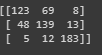

### 2.2 Regularização

- Dropout: é usado como comando na camada sequencial, afinal é algo arquitetural https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout#:~:text=tf.keras.layers.Dropout%20%28rate%2C%20noise_shape%3DNone%2C%20seed%3DNone%2C%20%2A%2Akwargs%29%20Used%20in%20the,that%20the%20sum%20over%20all%20inputs%20is%20unchanged.

- Early stopping: É o tipo de callback mais comum, deve ser chamado como parametro em em model.fit https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/#:~:text=Keras%20supports%20the%20early%20stopping%20of%20training%20via,EarlyStopping%20callback%20is%20configured%20when%20instantiated%20via%20arguments. Basicamente faremos o modelo parar quando do treinamento uma vez que temos uma estabilização da val_loss

- l2: Regularização mais comum. É usado como um comando após a camada de referencia na construção do model sequencial, conforme página 395 do HOML 


- Batch normalization : É um método que podemos usar para normalizar as entradas de cada camada para evitar o problema da covariância interna. Trata-se de uma comando após os comandos de camada dentro do modelo sequencial (normalmente na parte fully connected) https://towardsdatascience.com/batch-normalization-theory-and-how-to-use-it-with-tensorflow-1892ca0173ad

In [45]:
# Early stopping
ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [46]:
# L2
from functools import partial
RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))

In [50]:

def model_pipeline_opt():
    model = Sequential()
    model.add(Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=(im_size, im_size, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(RegularizedDense(200))                                    ## L2
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(rate=0.2))                           ## Dropout
    model.add(Dense(60, activation='relu'))
    model.add(Dropout(rate=0.2))                           ## Dropout
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
    return model

In [51]:
model = model_pipeline_opt()
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 63504)             0         
                                                                 
 dense_24 (Dense)            (None, 200)               12701000  
                                                                 
 dense_25 (Dense)            (None, 20)                4020      
                                                                 
 dropout_11 (Dropout)        (None, 20)                0         
                                                      

In [52]:
model.fit(train, 
          epochs = 10, 
          validation_data = valid, 
          batch_size = batch_size, 
          steps_per_epoch =  train.n//train.batch_size,
          validation_steps = valid.n//valid.batch_size,
          callbacks = ES
          )

Epoch 1/10
108/108 [==============================] - 18s 164ms/step - loss: 1.9834 - accuracy: 0.4162 - val_loss: 1.2428 - val_accuracy: 0.3292
Epoch 2/10
108/108 [==============================] - 17s 161ms/step - loss: 1.2479 - accuracy: 0.3944 - val_loss: 1.3003 - val_accuracy: 0.5542
Epoch 3/10
108/108 [==============================] - 17s 160ms/step - loss: 1.3300 - accuracy: 0.5241 - val_loss: 1.3866 - val_accuracy: 0.5625
Epoch 4/10
108/108 [==============================] - 17s 160ms/step - loss: 1.2491 - accuracy: 0.5514 - val_loss: 1.2071 - val_accuracy: 0.5542
Epoch 5/10
108/108 [==============================] - 17s 161ms/step - loss: 1.2691 - accuracy: 0.5486 - val_loss: 1.3007 - val_accuracy: 0.5250
Epoch 6/10
108/108 [==============================] - 17s 160ms/step - loss: 1.2436 - accuracy: 0.5505 - val_loss: 1.3218 - val_accuracy: 0.5292
Epoch 7/10
108/108 [==============================] - 17s 159ms/step - loss: 1.2416 - accuracy: 0.5583 - val_loss: 1.0553 - val_ac

Ao final, a acurácia fica semelhante (talvez um pouco mais baixa), mas o modelo consegue treinar mais rápido (sai de 3min para cerca de 1min).

## 3 Transfer Learning VGG16 e Resnet50
https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/#:~:text=Transfer%20learning%20involves%20using%20models%20trained%20on%20one,access%20to%20many%20top%20performing%20models%20on%20

"By default, the model expects color input images to be rescaled to the size of 224×224 squares."

### 3.1 VGG16 aplicada ao nosso dataset

No modelo abaixo, apenas a última camada foi adaptada. As imagens de entrada foram de 224x224 conforme paper https://arxiv.org/abs/1409.1556. Código de referencia https://medium.com/analytics-vidhya/cnn-transfer-learning-with-vgg16-using-keras-b0226c0805bd

In [53]:
#batch_size = 1
batch_size = 20
#batch_size = 100

#im_size = 32
im_size = 224
#im_size = 512

In [54]:
train = train_datagen.flow_from_directory( 
    directory = src_path_train,
    target_size = (im_size,im_size),
    color_mode = "rgb",
    batch_size = batch_size,
    class_mode = "categorical",
    subset = 'training',
    shuffle = True,
    seed = 42,
#    save_to_dir=aug_img_path, 
 #   save_prefix='aug', 
  #  save_format='jpeg'
)

valid = train_datagen.flow_from_directory(
    directory = src_path_train,
    target_size = (im_size,im_size),
    color_mode = "rgb",
    batch_size = batch_size,
    class_mode = "categorical",
    subset = 'validation',
    shuffle = True,
    seed = 42
)

test = test_datagen.flow_from_directory(
    directory = src_path_test,
    target_size = (im_size,im_size),
    color_mode = "rgb",
    batch_size = 1,
    class_mode = None,
    shuffle = False,
    seed = 42
)

Found 2160 images belonging to 3 classes.
Found 240 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


Abaixo importamos o modelo em si. Utilizamos o camando include_top = False para dizer que estamos tirando apenas a última camada de neurônios e buscando os pesos direto da imagenet. As imagens são 224 x 224

In [55]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
vgg=VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))
vgg.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

Congelamento de camadas conforme orientado no livro

In [56]:
for layer in vgg.layers:
   layer.trainable = False

Abaixo temos a construção da última camada de neurônios. A sequência dos comandos são idênticas à CNN anterior

In [57]:
x=Flatten()(vgg.output)
prediction=Dense(3,activation='softmax')(x)
model=Model(inputs=vgg.input,outputs=prediction)

In [58]:
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])


In [59]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [60]:
model.fit(train, 
          epochs = 10, 
          validation_data = valid, 
          batch_size = batch_size, 
          steps_per_epoch =  train.n//train.batch_size,
          validation_steps = valid.n//valid.batch_size
          )

Epoch 1/10
108/108 [==============================] - 43s 372ms/step - loss: 0.6691 - accuracy: 0.7231 - val_loss: 0.4442 - val_accuracy: 0.8250
Epoch 2/10
108/108 [==============================] - 40s 366ms/step - loss: 0.3992 - accuracy: 0.8333 - val_loss: 0.4368 - val_accuracy: 0.8125
Epoch 3/10
108/108 [==============================] - 39s 361ms/step - loss: 0.3939 - accuracy: 0.8389 - val_loss: 0.4228 - val_accuracy: 0.8417
Epoch 4/10
108/108 [==============================] - 39s 361ms/step - loss: 0.3977 - accuracy: 0.8551 - val_loss: 0.3829 - val_accuracy: 0.8167
Epoch 5/10
108/108 [==============================] - 39s 363ms/step - loss: 0.3391 - accuracy: 0.8745 - val_loss: 0.4421 - val_accuracy: 0.8333
Epoch 6/10
108/108 [==============================] - 39s 362ms/step - loss: 0.2965 - accuracy: 0.8806 - val_loss: 0.3368 - val_accuracy: 0.8750
Epoch 7/10
108/108 [==============================] - 39s 364ms/step - loss: 0.3081 - accuracy: 0.8745 - val_loss: 0.4429 - val_ac

In [61]:
score = model.evaluate(valid)
print("Loss ", score[0])
print("Accuracy ", score[1])

12/12 [==============================] - 4s 333ms/step - loss: 0.4893 - accuracy: 0.8417
Loss  0.48933929204940796
Accuracy  0.8416666388511658


Uau, quase 87% de acurária. Isso é uma melhora de mais de 20%

In [62]:
predict = model.predict(test)
y_predict = predict.argmax(axis = -1)

In [63]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(test.labels, y_predict)

print(cf_matrix)

[[178  22   0]
 [ 13 187   0]
 [  4  27 169]]


### 3.2 Resnet

Para Resnet50, as imagens de entrada têm as mesma dimensão que VGG. O resto do código abaixo foi adaptado do código apresentado no livro texto


In [64]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

## Loading VGG16 model
RN50=ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3))
RN50.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [65]:
for layer in RN50.layers:
   layer.trainable = False
x=Flatten()(RN50.output)
prediction=Dense(3,activation='softmax')(x)
model=Model(inputs=RN50.input,outputs=prediction)
optimizer = tf.keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer,
metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


 ization)                                                                                         
                                                                                                  
 conv3_block1_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block1_0_conv (Conv2D)   (None, 28, 28, 512)  131584      ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block1_2_relu[0][0]']    
                                                                                                  
 conv3_block1_0_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block1_0_conv[0][0]']    
 ization) 

Resnet precisa que os outputs estejam em tamanho 0 a 255 em vez de 0 a 1

In [66]:


src_path_train = "/content/Animal/train/"
src_path_test = "/content/Animal/test/"

train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=10,
        horizontal_flip=True,
        fill_mode="nearest",
        zoom_range=[0.8, 1.2],
        brightness_range = [0.75, 1.5],
        validation_split=0.10)

test_datagen = ImageDataGenerator()

In [67]:
train = train_datagen.flow_from_directory( 
    directory = src_path_train,
    target_size = (im_size,im_size),
    color_mode = "rgb",
    batch_size = batch_size,
    class_mode = "categorical",
    subset = 'training',
    shuffle = True,
    seed = 42,
#    save_to_dir=aug_img_path, 
 #   save_prefix='aug', 
  #  save_format='jpeg'
)

valid = train_datagen.flow_from_directory(
    directory = src_path_train,
    target_size = (im_size,im_size),
    color_mode = "rgb",
    batch_size = batch_size,
    class_mode = "categorical",
    subset = 'validation',
    shuffle = True,
    seed = 42
)

test = test_datagen.flow_from_directory(
    directory = src_path_test,
    target_size = (im_size,im_size),
    color_mode = "rgb",
    batch_size = 1,
    class_mode = None,
    shuffle = False,
    seed = 42
)

Found 2160 images belonging to 3 classes.
Found 240 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [68]:
model.fit(train, 
          epochs = 10, 
          validation_data = valid, 
          batch_size = batch_size, 
          steps_per_epoch =  train.n//train.batch_size,
          validation_steps = valid.n//valid.batch_size
          )

Epoch 1/10
108/108 [==============================] - 42s 360ms/step - loss: 1068.6155 - accuracy: 0.8694 - val_loss: 962.8692 - val_accuracy: 0.8917
Epoch 2/10
108/108 [==============================] - 38s 354ms/step - loss: 582.3887 - accuracy: 0.9315 - val_loss: 513.2188 - val_accuracy: 0.9292
Epoch 3/10
108/108 [==============================] - 38s 354ms/step - loss: 313.5088 - accuracy: 0.9569 - val_loss: 395.6920 - val_accuracy: 0.9333
Epoch 4/10
108/108 [==============================] - 38s 354ms/step - loss: 318.4607 - accuracy: 0.9519 - val_loss: 295.1120 - val_accuracy: 0.9458
Epoch 5/10
108/108 [==============================] - 38s 355ms/step - loss: 287.7228 - accuracy: 0.9616 - val_loss: 268.7039 - val_accuracy: 0.9458
Epoch 6/10
108/108 [==============================] - 38s 353ms/step - loss: 235.1601 - accuracy: 0.9644 - val_loss: 282.5534 - val_accuracy: 0.9458
Epoch 7/10
108/108 [==============================] - 39s 357ms/step - loss: 197.6467 - accuracy: 0.9667 

In [69]:
score = model.evaluate(valid)
print("Loss ", score[0])
print("Accuracy ", score[1])

12/12 [==============================] - 4s 326ms/step - loss: 203.6257 - accuracy: 0.9583
Loss  203.62567138671875
Accuracy  0.9583333134651184


In [70]:
predict = model.predict(test)
y_predict = predict.argmax(axis = -1)


#Generate the confusion matrix
cf_matrix = confusion_matrix(test.labels, y_predict)

print(cf_matrix)

[[193   7   0]
 [  2 198   0]
 [  0   0 200]]


Em minha máquina isso gerou o estraordinário resultado abaixo (cerca de 97% de acurácia): 

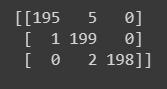

De fato uma classificação estremamente acurada.

## Códigos falhos

Abaixo eu apresento um pouco os pedaços de código que eventualmente tentei utilizar, para que se tenha uma breve ideia do meu processo criativo.

In [71]:
epochs = 50
batch_size = 10
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    steps_per_epoch=X_train.shape[0]//batch_size, 
                    validation_data=(X_test, y_test), 
                    validation_steps=X_test.shape[0]//batch_size, verbose = 1)
  
_, acc = model.evaluate(X_test, y_test, verbose = 1)
print('%.3f' % (acc * 100.0))
  
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], color = 'blue', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'red', label = 'val')
plt.legend()
plt.title('Accuracy')
plt.show()

NameError: ignored

In [ ]:
!pip install split-folders

import splitfolders

splitfolders.ratio("/content/animals/cats", output="cats2",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) # default values


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data generators
# File path = path to train/test/val folders respectively
# Use a target size of 224x224 px for each image (or whatever size you choose)
# Batch size = total number of images in the train set, test set, val set respectively
# Ensure class_mode is binary
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                    '/content/animals/cats',
                                                     target_size=(224, 224),
                                                     batch_size=800,
                                                     class_mode='binary',
                                                     seed=123)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras

data_generator = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = data_generator.flow_from_directory(
    '/content/animals/cats',
    target_size = (28, 28),
    batch_size = 86,
    class_mode = 'binary',
    color_mode='rgb',
    classes=None, subset="training"
)

validation_generator = data_generator.flow_from_directory(
    '/content/animals/cats',
    target_size = (28, 28),
    batch_size = 86,
    class_mode = 'binary',
    color_mode='rgb',
    classes=None, subset="validation"
)

#history=classifier.fit_generator(
 #   train_generator,
  #  steps_per_epoch = (8000 / 86),
   # epochs = 2,
   # validation_data = validation_generator,
   # validation_steps = 8000/86,
   # callbacks=[learning_rate_reduction]
#)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        '/content/animals/cats',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        '/content/animals/cats',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
model.fit(
        train_generator,
        steps_per_epoch=2000,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800)



In [ ]:
from sklearn.model_selection import train_test_split

train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                    '/content/animai/train',
                                                     target_size=(224, 224),
                                                     batch_size=5216,
                                                     class_mode='binary',
                                                     seed=123)

train_generator = train_datagen.flow_from_directory(
    '/content/Animal/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                    '/content/chest_xray/test',
                                                     target_size=(224, 224),
                                                     batch_size=624,
                                                     class_mode='binary',
                                                     seed=123)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                    '/content/chest_xray/val',
                                                     target_size=(224, 224),
                                                     batch_size=16,
                                                     class_mode='binary',
                                                     seed=123)

# Iterate through each generator to create the data sets with the train/test/val splits
X_train, y_train = next(train_generator)
X_test, y_test = next(test_generator)
X_val, y_val = next(val_generator)

# Check which class is which
train_generator.class_indices